In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [87]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites = []

    # Find active sites
    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr:
                active_sites.append((i, j))

    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 1

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L)
    initial_state = np.copy(F)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()


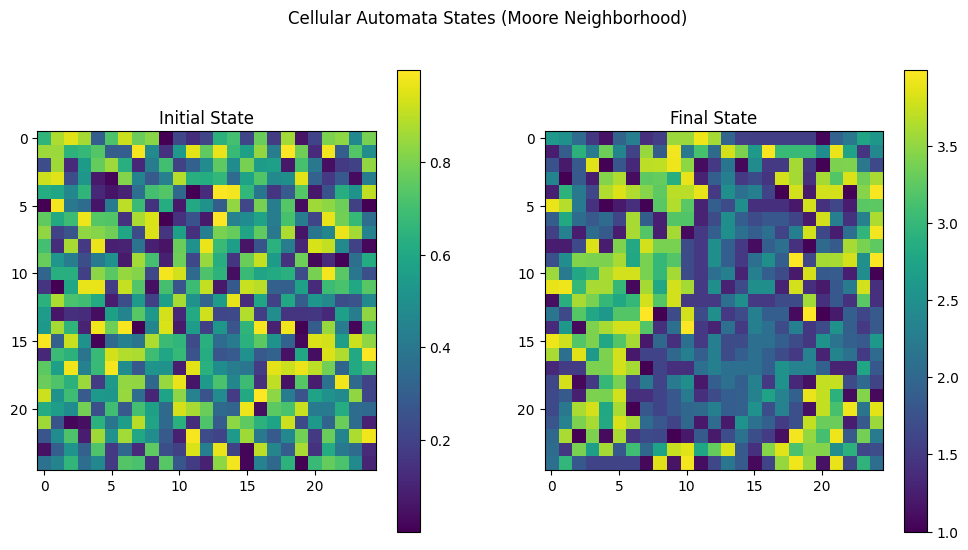

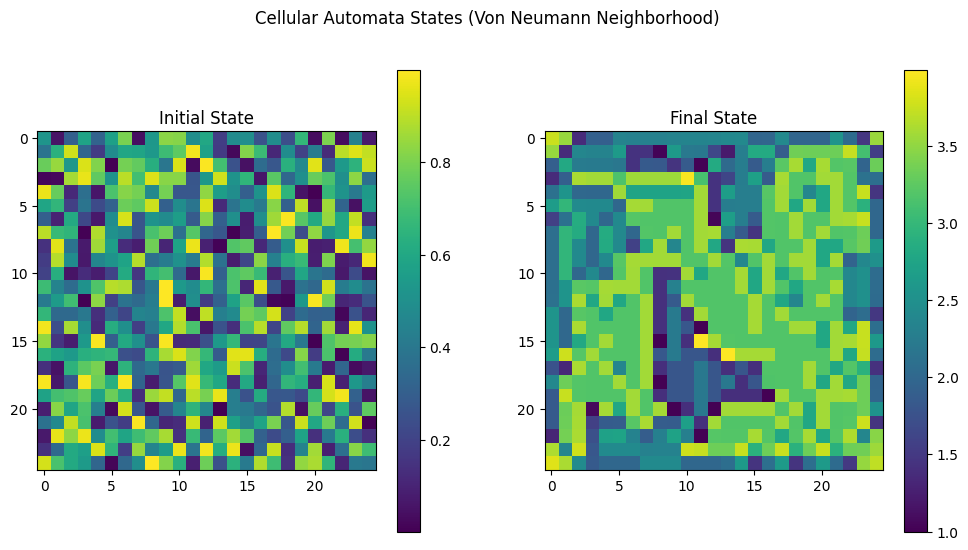

In [88]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.4  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 1000 # Number of additions of force to the system

# Run the simulation for Moore neighborhood
initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood
visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run the simulation for Von Neumann neighborhood
initial_state_von, final_state_von, active_sites_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood
visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')

In [89]:
# Run the simulation for Moore neighborhood multiple times
n_simulations = 1
active_sites_moore_array = []
for i in range(n_simulations):
    initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
    active_sites_moore_array.append(active_sites_moore)

In [90]:
# take all values of active sites and put them in one array
active_sites_all_moore = []
for i in range(n_simulations):
    active_sites_all_moore += active_sites_moore_array[i]
active_sites_all_moore = np.array(active_sites_all_moore)

# calculate the frequency
all_values_moore, all_counts_moore = np.unique(active_sites_all_moore, return_counts=True)
all_freq_moore = all_counts_moore / len(active_sites_all_moore)

# calculate the rank
all_rank_moore = np.arange(1, len(all_values_moore)+1)

In [91]:
# Define a negative power law function
def neg_power_law(x, a, b):
    return a * x ** b

# Fit the negative power law to the data using curve_fit
params, _ = curve_fit(neg_power_law, all_values_moore, all_freq_moore, method='lm')

# Generate fitted values using the parameters obtained from curve_fit
all_fitted = neg_power_law(all_values_moore, *params)



/tmp/ipykernel_19826/2977582254.py:3: RuntimeWarning: divide by zero encountered in power
  return a * x ** b


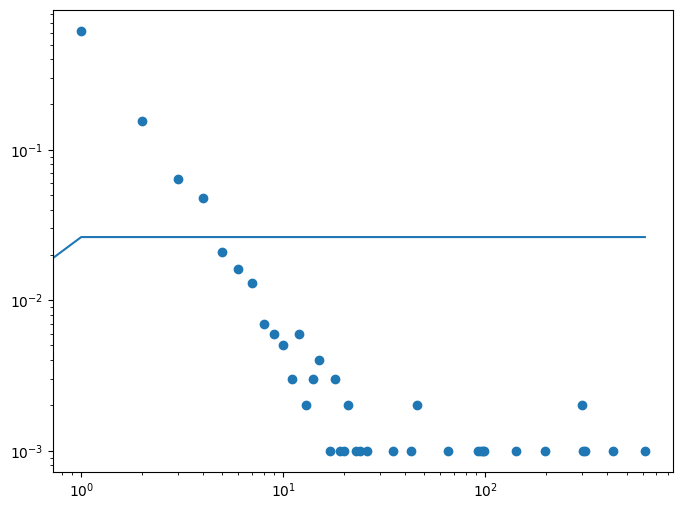

In [92]:
plt.figure(figsize=(8, 6))
plt.scatter(all_values_moore, all_freq_moore, label='Data')
plt.plot(all_values_moore, all_fitted, label='Fit')
plt.xscale('log')
plt.yscale('log')

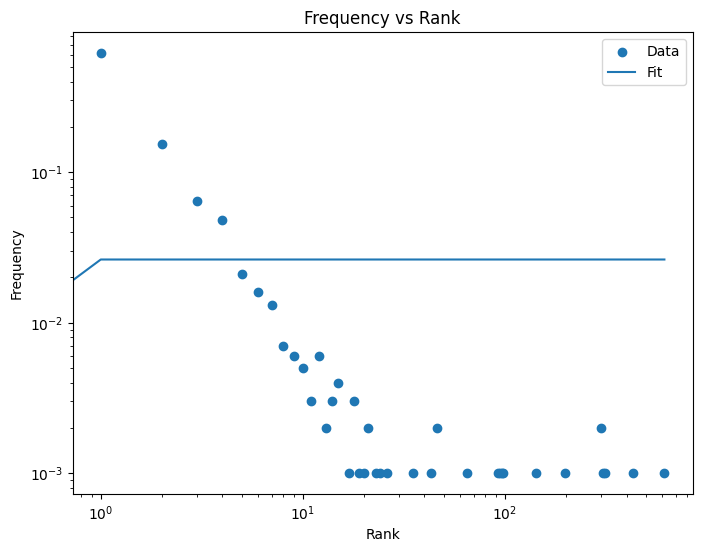

In [93]:
# Plot the frequency vs rank
plt.figure(figsize=(8, 6))
plt.scatter(all_values_moore, all_freq_moore, label='Data')
plt.plot(all_values_moore, all_fitted, label='Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Frequency vs Rank')
plt.legend()
plt.show()

/tmp/ipykernel_19826/2663774298.py:14: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, -b)


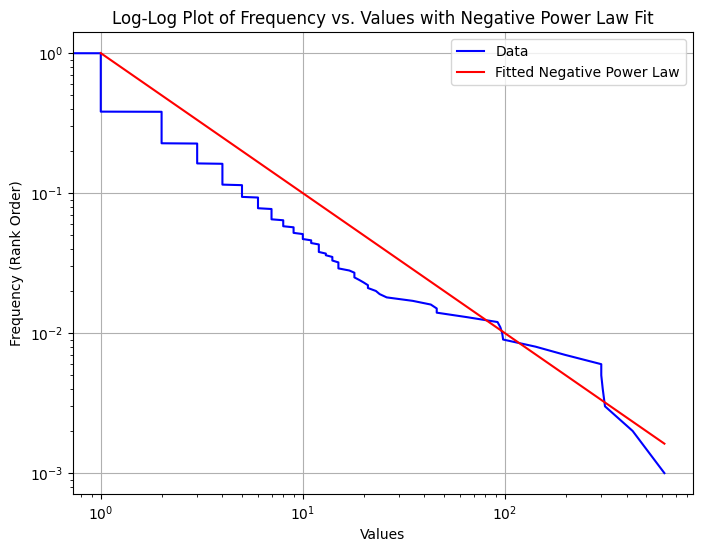

In [94]:
# Generate some data with a negative power law distribution
# For demonstration, let's create a sample array with a negative exponent
values = active_sites_moore  # 'a' is the exponent parameter

# Calculate the frequencies of each value
values_sorted = np.sort(values)
frequencies = np.arange(1, len(values_sorted) + 1) / len(values_sorted)

# Inverse the frequencies to get the ranks
ranks = frequencies[::-1]

# Define a negative power law function
def neg_power_law(x, a, b):
    return a * np.power(x, -b)

# Fit the negative power law to the data using curve_fit
params, _ = curve_fit(neg_power_law, values_sorted, ranks)

# Generate fitted values using the parameters obtained from curve_fit
fitted_ranks = neg_power_law(values_sorted, *params)

# Make a log-log plot of the data and the fitted curve
plt.figure(figsize=(8, 6))
plt.loglog(values_sorted, ranks, color='b', label='Data')
plt.loglog(values_sorted, fitted_ranks, 'r-', label='Fitted Negative Power Law')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency (Rank Order)')
plt.title('Log-Log Plot of Frequency vs. Values with Negative Power Law Fit')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

/tmp/ipykernel_19826/2663774298.py:14: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, -b)


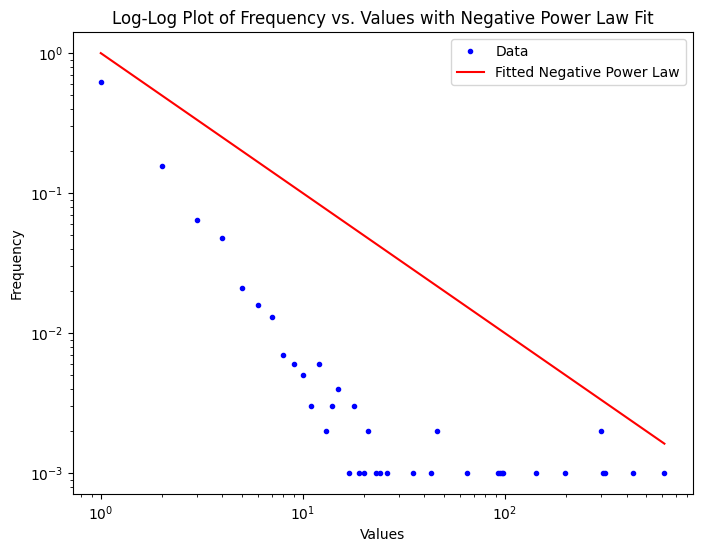

In [95]:
# plot the frequency
plt.figure(figsize=(8, 6))
plt.loglog(all_values_moore, all_freq_moore, 'b.', label='Data')
plt.loglog(all_values_moore, neg_power_law(all_values_moore, *params), 'r-', label='Fitted Negative Power Law')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Log-Log Plot of Frequency vs. Values with Negative Power Law Fit')
plt.legend()

Counter({1: 660, 2: 90, 3: 62, 4: 43, 5: 27, 7: 18, 6: 15, 11: 12, 27: 10, 29: 5, 150: 5, 47: 5, 51: 4, 24: 3, 40: 3, 46: 3, 12: 2, 31: 2, 39: 2, 8: 2, 153: 2, 36: 2, 23: 2, 25: 2, 30: 2, 19: 2, 0: 1, 489: 1, 113: 1, 38: 1, 265: 1, 65: 1, 60: 1, 10: 1, 50: 1, 57: 1, 48: 1, 15: 1, 42: 1, 45: 1, 20: 1})


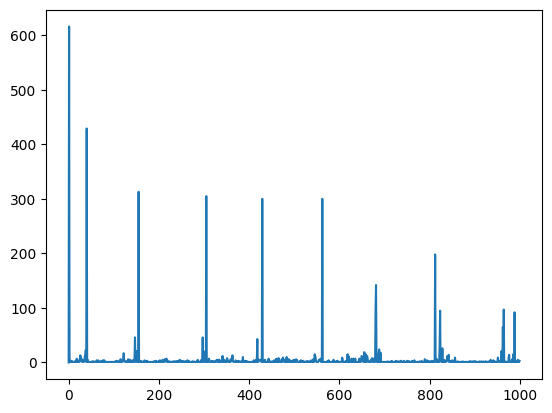

In [96]:
plt.plot(active_sites_moore, label='Moore')
from collections import Counter
occurrences_counter = Counter(active_sites_von)
print(occurrences_counter)

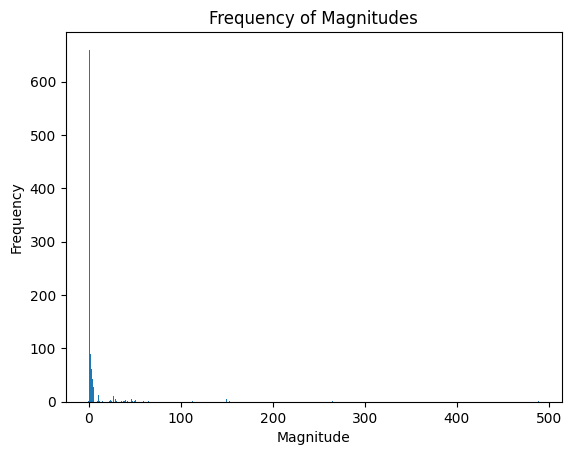

In [97]:
sorted_data = dict(sorted(occurrences_counter.items()))
magnitudes = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.bar(magnitudes, frequencies)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Frequency of Magnitudes')
plt.show()

In [ ]:
n_simulations = 50
active_sites_moore_array = []
for i in range(n_simulations):
    print(i)
    _, _, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')
    active_sites_moore_array.append(active_sites_moore)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [ ]:
flattened_list = [item for sublist in active_sites_moore_array for item in sublist]
print(len(flattened_list))
#plt.plot(flattened_list, label='Moore')

occurrences_counter = Counter(active_sites_von)
print(occurrences_counter)

sorted_data = dict(sorted(occurrences_counter.items()))
#agnitudes = list(sorted_data.keys())
#frequencies = list(sorted_data.values())

magnitudes = list(occurrences_counter.keys())

frequencies = list(occurrences_counter.values())
plt.scatter(magnitudes, frequencies)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Frequency of Magnitudes')
plt.show()


In [ ]:
from scipy.stats import linregress

values = np.array(list(occurrences_counter.keys()))
frequencies = np.array(list(occurrences_counter.values()))

print(frequencies)

non_zero_indices = values > 0
values = values[non_zero_indices]
frequencies = frequencies[non_zero_indices]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(np.log(values), np.log(frequencies))

# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(np.log(values), np.log(frequencies), color='blue', alpha=0.6)
plt.xlabel('log(Value)')
plt.ylabel('log(Frequency)')
plt.title('Log-log plot of the data')

# Plot the regression line
x = np.linspace(min(np.log(values)), max(np.log(values)), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linestyle='--', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()

plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)

In [ ]:
pip install powerlaw